# **Predicting Hospital Readmission Rates for Diabetic Patients**


# **Data Import**

In [1]:
# Importing packages
import numpy as np
import pandas as pd
import random
import os
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

from scipy import optimize
from sklearn import datasets as skdataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from pathlib import Path

from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset

import sqlite3

%matplotlib inline

In [2]:
# MODIFY THE LOCATION OF THE DATA HERE

from google.colab import drive
drive_mount = True
if drive_mount:
  drive.mount('/content/drive')
if drive_mount:
  dataset_path = '/content/drive/MyDrive/'
  assert(os.path.exists(dataset_path))
else:
  dataset_path = "./mental_health.sqlite"

# Loading and preparing diabetes dataset for machine learning, separating target variable and features
db_file_path = '/content/drive/MyDrive/mental_health.sqlite'

# Create a connection to the SQLite database
conn = sqlite3.connect(db_file_path)

# Use the connection to execute an SQL query and read the entire table into a Pandas DataFrame
survey = pd.read_sql_query("SELECT * FROM Survey", conn)
question = pd.read_sql_query("SELECT * FROM Question", conn)
answer = pd.read_sql_query("SELECT * FROM Answer", conn)

# Close the database connection
conn.close()

survey

Mounted at /content/drive


,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


In [ ]:
question
background_qs = [1,2,3,4,20,50,51,89]
employment_qs = [5,8,9,13,68,93,94,117,118]
mental_health_id_qs = [78,115,116]
mental_health_history_qs = [6,7,32,33,34]
employer_support_qs = [10,11,14,15,16,17,64,65,91,94,95,96,97,101,108]
previous_employer_qs = [22,23,24,25,26,27,69,70,71,72,73,74,75,76,77,110,111,112]
mental_health_communication_qs = [18,19,28,30,52,53,57,58,59,60,61,62,63,66,67,99,100,114]
impact_on_work_qs = [48,49,54,55,79,80,90,92,98,104,106,107,108,109,113]
workplace_observations_qs = [56,82,83,84,102,105]
industry_perception_qs = [12,29,81,85,86,101]
additional_qs = [21,87,88,103]

In [ ]:
question

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5
...,...,...
100,Do you think that team members/co-workers woul...,114
101,"If yes, what condition(s) have you been diagno...",115
102,"If maybe, what condition(s) do you believe you...",116
103,Which of the following best describes your wor...,117


In [ ]:
answer

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1
...,...,...,...,...
236893,Other,2016,2689,117
236894,Support,2016,2690,117
236895,Back-end Developer,2016,2691,117
236896,DevOps/SysAdmin,2016,2692,117


# **Data Transformation & Exploration**

**Data Visualisation**

In [3]:
# Create a table showing which QuestionIDs appear in which SurveyIDs
question_survey_table = answer.groupby(['SurveyID', 'QuestionID']).size().unstack(fill_value=0)

# Print the table
print(question_survey_table.to_string())

QuestionID   1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    48    49    50    51    52    53    54    55    56   57   58   59   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80   81   82   83   84   85   86   87   88   89    90    91    92    93    94    95    96    97    98    99    100   101   102   103   104   105   106   107   108   109   110   111   112   113   114   115   116   117   118
SurveyID                                                                                                                                                                                                                                                                                                                                                                                                

In [25]:
df = answer.pivot_table(index=['SurveyID', 'UserID'], columns='QuestionID', values='AnswerText', aggfunc='first')

# Reset the index if needed
df.reset_index(inplace=True)

df.columns

Index(['SurveyID',   'UserID',          1,          2,          3,          4,
                5,          6,          7,          8,
       ...
              109,        110,        111,        112,        113,        114,
              115,        116,        117,        118],
      dtype='object', name='QuestionID', length=107)

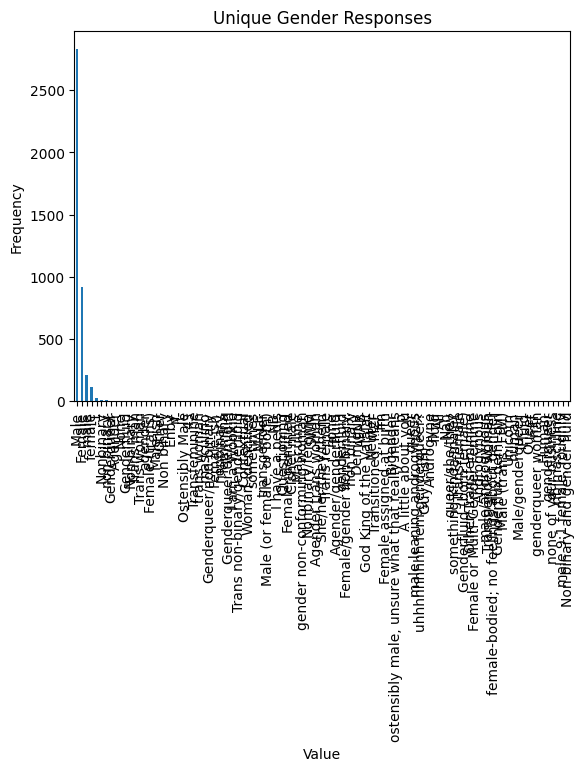

In [26]:
genders = df[2]

# Plot the frequency of each value
genders.value_counts().plot(kind='bar')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Unique Gender Responses')
plt.show()

In [28]:
def categorize_gender(gender):
    if gender.lower() in ['Male', 'male', 'MALE']:
        return 'Male'
    elif gender.lower() in ['Female', 'female', 'Female-identified']:
        return 'Female'
    elif gender == '-1':
        return '-1'
    else:
        return 'Other'

# Apply the function to the '2' column
df[2] = df[2].apply(categorize_gender)

# Now the '2' column should have only 'Male', 'Female', or 'Other' values
print(df[2].unique())

['Female' 'Male' 'Other' '-1']


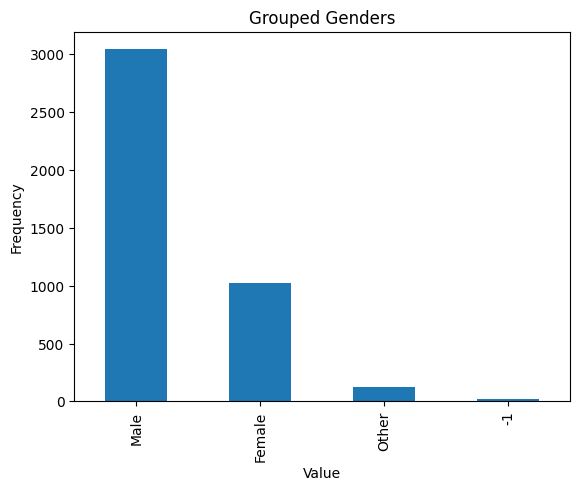

In [29]:
genders = df[2]

# Plot the frequency of each value
genders.value_counts().plot(kind='bar')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Grouped Genders')
plt.show()

Some of them    610
No              196
Yes             185
Name: 99, dtype: int64


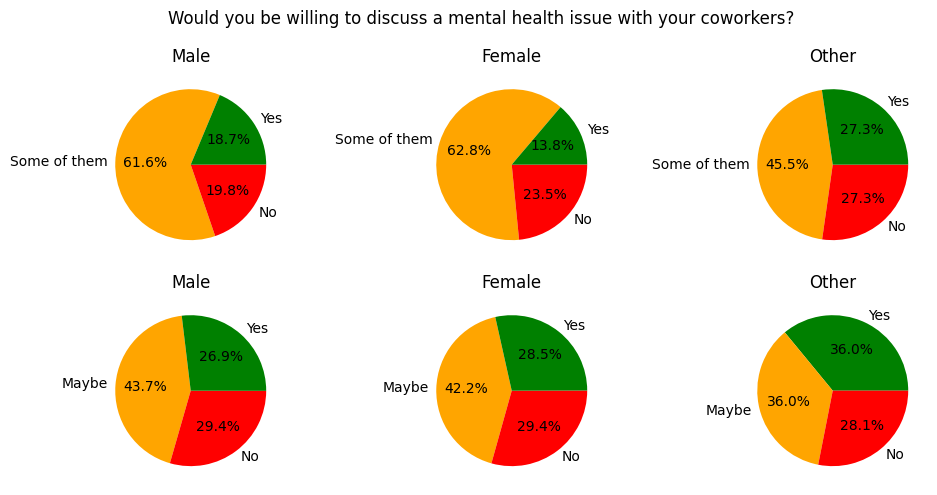

In [51]:
df_male = df.loc[df[2].eq('Male')]
df_female = df.loc[df[2].eq('Female')]
df_other = df.loc[df[2].eq('Other')]
male_99 = df_male.loc[df_male[99] != '-1'][99].value_counts()
female_99 = df_female.loc[df_female[99] != '-1'][99].value_counts()
other_99 = df_other.loc[df_other[99] != '-1'][99].value_counts()
print(male_99)
# Create a figure with 3 subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

colors = ['orange', 'red', 'green']
# Plot the first pie chart
axs[0][0].pie(male_99, labels=male_99.index, autopct='%1.1f%%', colors = colors, startangle=67.32)
axs[0][0].set_title('Male')

# Plot the second pie chart
axs[0][1].pie(female_99, labels=female_99.index, autopct='%1.1f%%', colors = colors, startangle=49.68)
axs[0][1].set_title('Female')

# Plot the third pie chart
axs[0][2].pie(other_99, labels=other_99.index, autopct='%1.1f%%', colors = colors, startangle=98.28)
axs[0][2].set_title('Other')

male_18 = df_male.loc[df_male[18] != '-1'][18].value_counts()
female_18 = df_female.loc[df_female[18] != '-1'][18].value_counts()
other_18 = df_other.loc[df_other[18] != '-1'][18].value_counts()

axs[1][0].pie(male_18, labels=male_18.index, autopct='%1.1f%%', colors = colors, startangle=96.84)
axs[1][0].set_title('Male')

# Plot the second pie chart
axs[1][1].pie(female_18, labels=female_18.index, autopct='%1.1f%%', colors = colors,startangle=102.6)
axs[1][1].set_title('Female')

# Plot the third pie chart
axs[1][2].pie(other_18, labels=other_18.index, autopct='%1.1f%%', colors = ['green','orange', 'red'])
axs[1][2].set_title('Other')

# Adjust layout to fit the titles
plt.suptitle('Would you be willing to discuss a mental health issue with your coworkers?', fontsize=12)
plt.tight_layout()
# Show the plot
plt.show()

In [9]:
print("Chi-Squared Test")
print("Gender vs Willingness to discuss a mental health issue with coworkers")


contingency_table = pd.crosstab(df[2], df[18])

# Perform the chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared: {chi2}")
print(f"P-value: {p}")

Chi-Squared Test
Gender vs Willingness to discuss a mental health issue with coworkers
Chi-squared: 7.9545775950535695
P-value: 0.24144999694007394


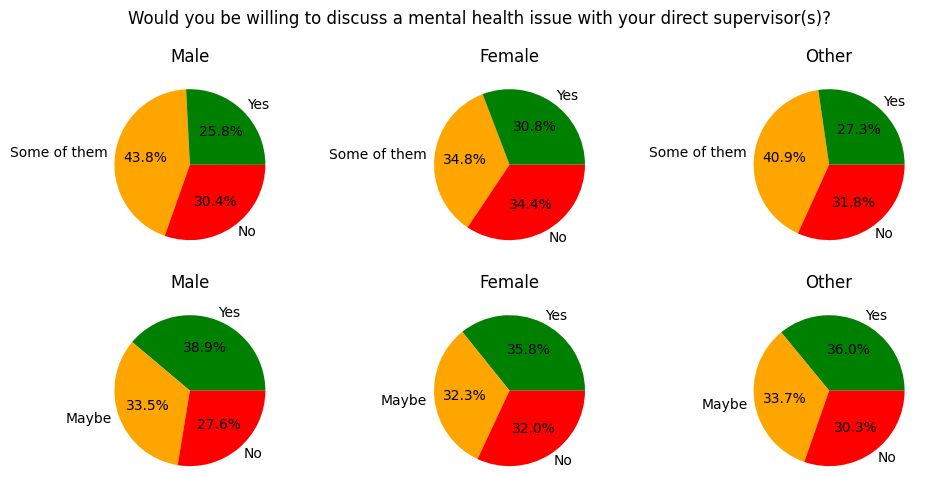

In [52]:
df_male = df.loc[df[2].eq('Male')]
df_female = df.loc[df[2].eq('Female')]
df_other = df.loc[df[2].eq('Other')]
male_100 = df_male.loc[df_male[100] != '-1'][100].value_counts()
female_100 = df_female.loc[df_female[100] != '-1'][100].value_counts()
other_100 = df_other.loc[df_other[100] != '-1'][100].value_counts()

# Create a figure with 3 subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

colors = ['orange', 'red', 'green']
# Plot the first pie chart
axs[0][0].pie(male_100, labels=other_100.index, autopct='%1.1f%%', colors = colors, startangle=92.88)
axs[0][0].set_title('Male')

# Plot the second pie chart
axs[0][1].pie(female_100, labels=other_100.index, autopct='%1.1f%%', colors = colors, startangle=110.88)
axs[0][1].set_title('Female')

# Plot the third pie chart
axs[0][2].pie(other_100, labels=other_100.index, autopct='%1.1f%%', colors = colors, startangle=98.28)
axs[0][2].set_title('Other')

male_19 = df_male.loc[df_male[19] != '-1'][19].value_counts()
female_19 = df_female.loc[df_female[19] != '-1'][19].value_counts()
other_19 = df_other.loc[df_other[19] != '-1'][19].value_counts()

axs[1][0].pie(male_19, labels=male_19.index, autopct='%1.1f%%', colors = ['green','orange', 'red'])
axs[1][0].set_title('Male')

# Plot the second pie chart
axs[1][1].pie(female_19, labels=female_19.index, autopct='%1.1f%%', colors = ['green','orange', 'red'])
axs[1][1].set_title('Female')

# Plot the third pie chart
axs[1][2].pie(other_19, labels=other_19.index, autopct='%1.1f%%', colors = ['green','orange', 'red'])
axs[1][2].set_title('Other')

# Adjust layout to fit the titles
plt.suptitle('Would you be willing to discuss a mental health issue with your direct supervisor(s)?', fontsize=12)
plt.tight_layout()
# Show the plot
plt.show()

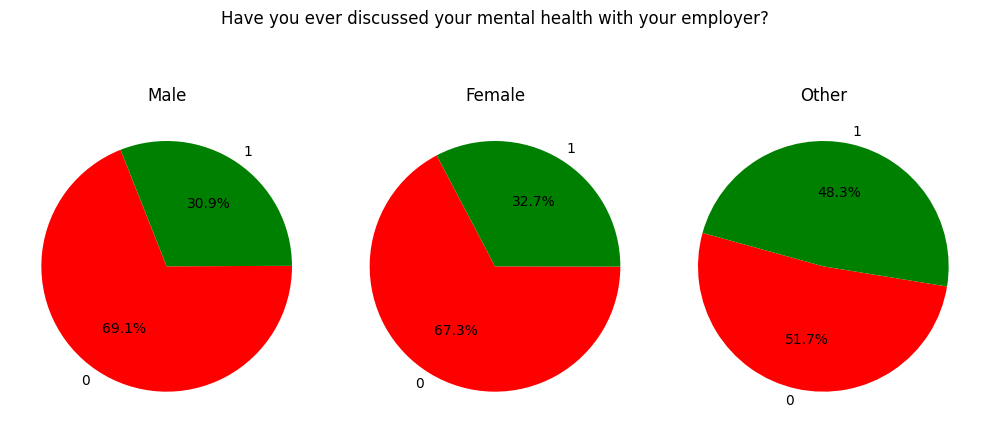

In [53]:
df_male = df.loc[df[2].eq('Male')]
df_female = df.loc[df[2].eq('Female')]
df_other = df.loc[df[2].eq('Other')]
male_58 = df_male.loc[df_male[58] != '-1'][58].value_counts()
female_58 = df_female.loc[df_female[58] != '-1'][58].value_counts()
other_58 = df_other.loc[df_other[58] != '-1'][58].value_counts()

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

colors = ['red', 'green']
# Plot the first pie chart
axs[0].pie(male_58, labels=male_58.index, autopct='%1.1f%%', colors = colors, startangle=111.6)
axs[0].set_title('Male')

# Plot the second pie chart
axs[1].pie(female_58, labels=female_58.index, autopct='%1.1f%%', colors = colors, startangle=117.72)
axs[1].set_title('Female')

# Plot the third pie chart
axs[2].pie(other_58, labels=other_58.index, autopct='%1.1f%%', colors = colors, startangle=164.52)
axs[2].set_title('Other')

# Adjust layout to fit the titles
plt.suptitle('Have you ever discussed your mental health with your employer?', fontsize=12)
plt.tight_layout()
# Show the plot
plt.show()

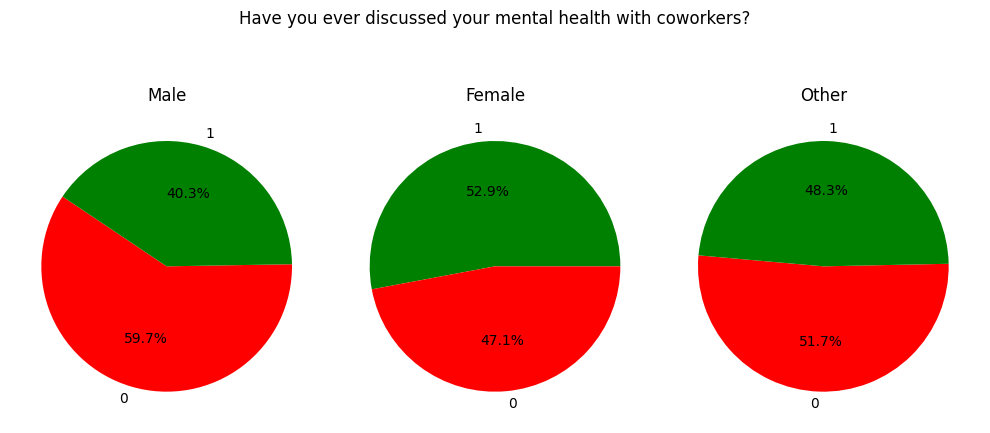

In [54]:
df_male = df.loc[df[2].eq('Male')]
df_female = df.loc[df[2].eq('Female')]
df_other = df.loc[df[2].eq('Other')]
male_60 = df_male.loc[df_male[60] != '-1'][60].value_counts()
female_60 = df_female.loc[df_female[60] != '-1'][60].value_counts()
other_60 = df_other.loc[df_other[60] != '-1'][60].value_counts()

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

colors = ['red', 'green']
# Plot the first pie chart
axs[0].pie(male_60, labels=male_60.index, autopct='%1.1f%%', colors = colors, startangle=146.16)
axs[0].set_title('Male')

# Plot the second pie chart
axs[1].pie(female_60, labels=female_60.index, autopct='%1.1f%%', colors = ['green', 'red'], startangle=0)
axs[1].set_title('Female')

# Plot the third pie chart
axs[2].pie(other_60, labels=other_60.index, autopct='%1.1f%%', colors = colors, startangle=174.96)
axs[2].set_title('Other')

# Adjust layout to fit the titles
plt.suptitle('Have you ever discussed your mental health with coworkers?', fontsize=12)
plt.tight_layout()
# Show the plot
plt.show()

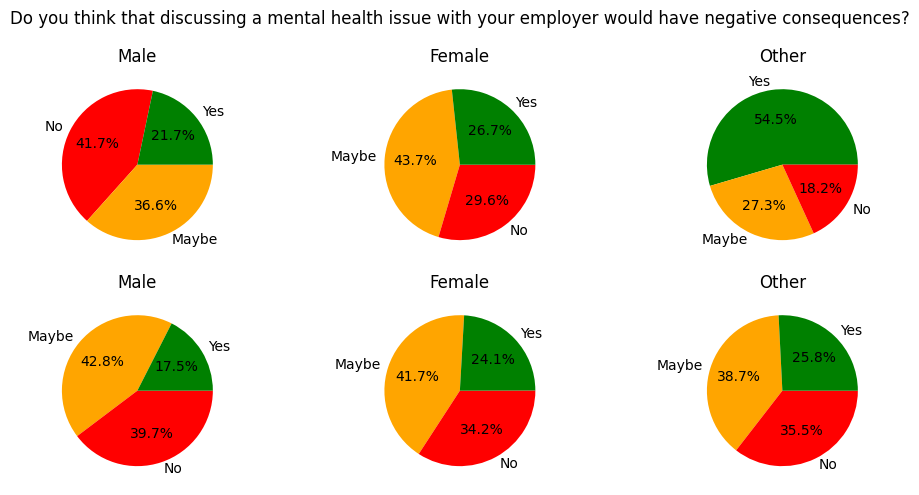

In [24]:
df_male = df.loc[df[2].eq('Male')]
df_female = df.loc[df[2].eq('Female')]
df_other = df.loc[df[2].eq('Other')]
male_98 = df_male.loc[df_male[98] != '-1'][98].value_counts()
female_98 = df_female.loc[df_female[98] != '-1'][98].value_counts()
other_98 = df_other.loc[df_other[98] != '-1'][98].value_counts()

# Create a figure with 3 subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

colors = ['orange', 'red', 'green']
# Plot the first pie chart
axs[0][0].pie(male_98, labels=male_98.index, autopct='%1.1f%%', colors = ['red', 'orange', 'green'], startangle=78.12)
axs[0][0].set_title('Male')

# Plot the second pie chart
axs[0][1].pie(female_98, labels=female_98.index, autopct='%1.1f%%', colors = colors, startangle=96.12)
axs[0][1].set_title('Female')

# Plot the third pie chart
axs[0][2].pie(other_98, labels=other_98.index, autopct='%1.1f%%', colors = ['green', 'orange', 'red'], startangle=0)
axs[0][2].set_title('Other')

male_104 = df_male.loc[df_male[104] != '-1'][104].value_counts()
female_104 = df_female.loc[df_female[104] != '-1'][104].value_counts()
other_104 = df_other.loc[df_other[104] != '-1'][104].value_counts()

axs[1][0].pie(male_104, labels=male_104.index, autopct='%1.1f%%', colors = colors, startangle=63)
axs[1][0].set_title('Male')

# Plot the second pie chart
axs[1][1].pie(female_104, labels=female_104.index, autopct='%1.1f%%', colors = colors,startangle=86.76)
axs[1][1].set_title('Female')

# Plot the third pie chart
axs[1][2].pie(other_104, labels=other_104.index, autopct='%1.1f%%', colors = colors,startangle=92.88)
axs[1][2].set_title('Other')

# Adjust layout to fit the titles
plt.suptitle('Do you think that discussing a mental health issue with your employer would have negative consequences?', fontsize=12)
plt.tight_layout()
# Show the plot
plt.show()

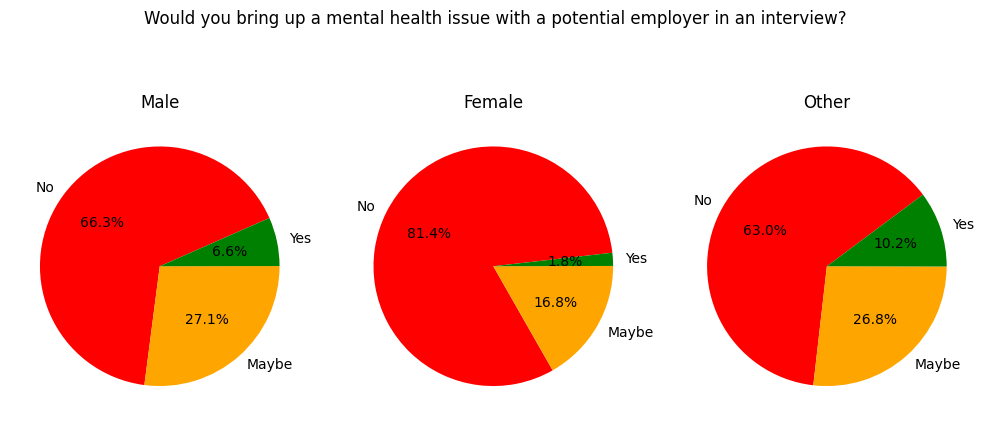

In [58]:
df_male = df.loc[df[2].eq('Male')]
df_female = df.loc[df[2].eq('Female')]
df_other = df.loc[df[2].eq('Other')]
male_12 = df_male.loc[df_male[12] != '-1'][12].value_counts()
female_12 = df_female.loc[df_female[12] != '-1'][12].value_counts()
other_12 = df_other.loc[df_other[12] != '-1'][12].value_counts()

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

colors = ['red', 'orange', 'green']
# Plot the first pie chart
axs[0].pie(male_12, labels=male_12.index, autopct='%1.1f%%', colors = colors, startangle=23.76)
axs[0].set_title('Male')

# Plot the second pie chart
axs[1].pie(female_12, labels=female_12.index, autopct='%1.1f%%', colors = colors, startangle=6.48)
axs[1].set_title('Female')

# Plot the third pie chart
axs[2].pie(other_12, labels=other_12.index, autopct='%1.1f%%', colors = colors, startangle=36.72)
axs[2].set_title('Other')

# Adjust layout to fit the titles
plt.suptitle('Would you bring up a mental health issue with a potential employer in an interview?', fontsize=12)
plt.tight_layout()
# Show the plot
plt.show()

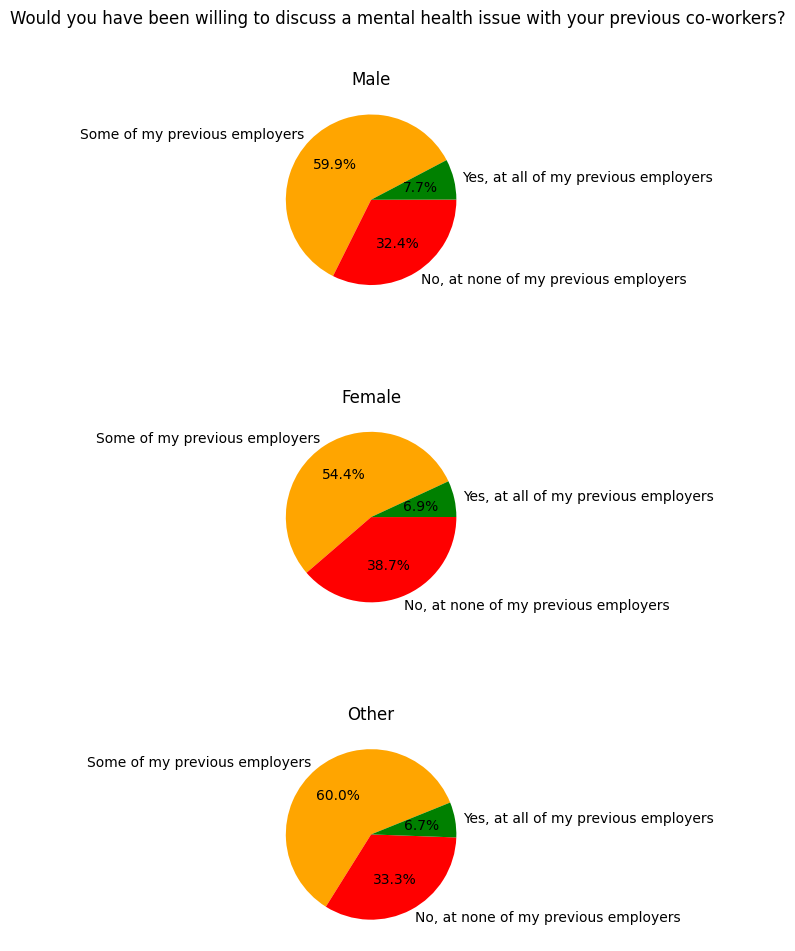

In [60]:
df_male = df.loc[df[2].eq('Male')]
df_female = df.loc[df[2].eq('Female')]
df_other = df.loc[df[2].eq('Other')]
male_110 = df_male.loc[df_male[110] != '-1'][110].value_counts()
female_110 = df_female.loc[df_female[110] != '-1'][110].value_counts()
other_110 = df_other.loc[df_other[110] != '-1'][110].value_counts()

# Create a figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(5, 10))

colors = ['orange', 'red', 'green']
# Plot the first pie chart
axs[0].pie(male_110, labels=male_110.index, autopct='%1.1f%%', colors = colors, startangle=27.72)
axs[0].set_title('Male')

# Plot the second pie chart
axs[1].pie(female_110, labels=female_110.index, autopct='%1.1f%%', colors = colors, startangle=24.84)
axs[1].set_title('Female')

# Plot the third pie chart
axs[2].pie(other_110, labels=other_110.index, autopct='%1.1f%%', colors = colors, startangle=21.96)
axs[2].set_title('Other')

# Adjust layout to fit the titles
plt.suptitle('Would you have been willing to discuss a mental health issue with your previous co-workers?', fontsize=12)
plt.tight_layout()
# Show the plot
plt.show()

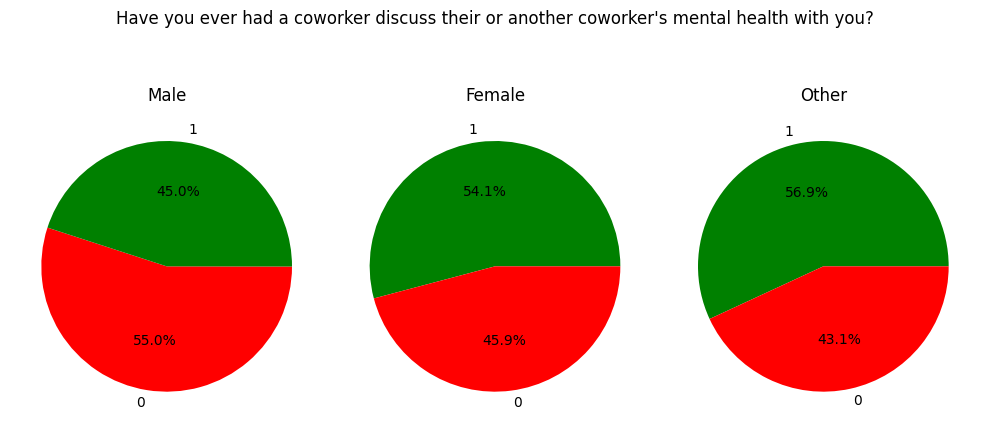

In [61]:
df_male = df.loc[df[2].eq('Male')]
df_female = df.loc[df[2].eq('Female')]
df_other = df.loc[df[2].eq('Other')]
male_62 = df_male.loc[df_male[62] != '-1'][62].value_counts()
female_62 = df_female.loc[df_female[62] != '-1'][62].value_counts()
other_62 = df_other.loc[df_other[62] != '-1'][62].value_counts()

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

colors = ['red','green']
# Plot the first pie chart
axs[0].pie(male_62, labels=male_62.index, autopct='%1.1f%%', colors = colors, startangle=162)
axs[0].set_title('Male')

# Plot the second pie chart
axs[1].pie(female_62, labels=female_62.index, autopct='%1.1f%%', colors = ['green','red'], startangle=0)
axs[1].set_title('Female')

# Plot the third pie chart
axs[2].pie(other_62, labels=other_62.index, autopct='%1.1f%%', colors = ['green','red'], startangle=0)
axs[2].set_title('Other')

# Adjust layout to fit the titles
plt.suptitle('Have you ever had a coworker discuss their or another coworker\'s mental health with you?', fontsize=12)
plt.tight_layout()
# Show the plot
plt.show()

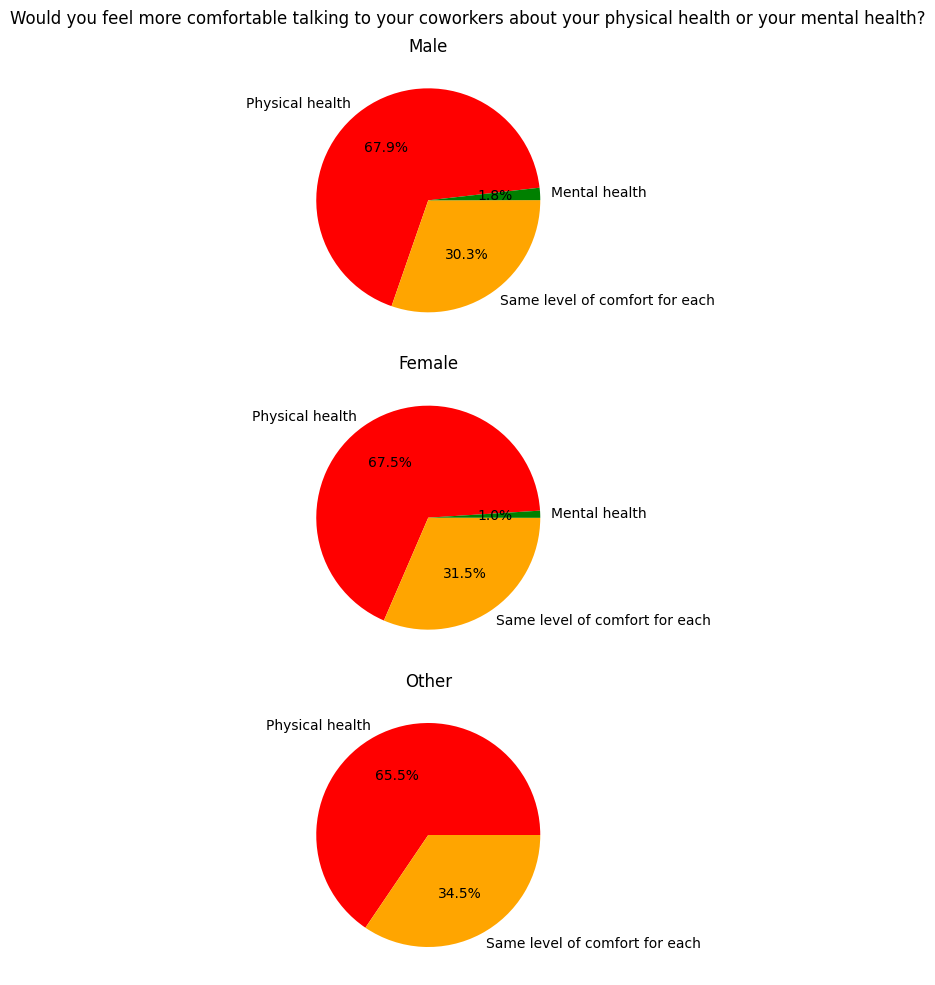

In [62]:
df_male = df.loc[df[2].eq('Male')]
df_female = df.loc[df[2].eq('Female')]
df_other = df.loc[df[2].eq('Other')]
male_57 = df_male.loc[df_male[57] != '-1'][57].value_counts()
female_57 = df_female.loc[df_female[57] != '-1'][57].value_counts()
other_57 = df_other.loc[df_other[57] != '-1'][57].value_counts()

# Create a figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(5, 10))

colors = ['red', 'orange', 'green']
# Plot the first pie chart
axs[0].pie(male_57, labels=male_57.index, autopct='%1.1f%%', colors = colors, startangle=6.48)
axs[0].set_title('Male')

# Plot the second pie chart
axs[1].pie(female_57, labels=female_57.index, autopct='%1.1f%%', colors = colors, startangle=3.6)
axs[1].set_title('Female')

# Plot the third pie chart
axs[2].pie(other_57, labels=other_57.index, autopct='%1.1f%%', colors = colors, startangle=0)
axs[2].set_title('Other')

# Adjust layout to fit the titles
plt.suptitle('Would you feel more comfortable talking to your coworkers about your physical health or your mental health?', fontsize=12)
plt.tight_layout()
# Show the plot
plt.show()

In [39]:
df = answer.pivot_table(index=['SurveyID', 'UserID'], columns='QuestionID', values='AnswerText', aggfunc='first')

# Reset the index if needed
df.reset_index(inplace=True)

df.columns

Index(['SurveyID',   'UserID',          1,          2,          3,          4,
                5,          6,          7,          8,
       ...
              109,        110,        111,        112,        113,        114,
              115,        116,        117,        118],
      dtype='object', name='QuestionID', length=107)

[nan '-1' 'White' 'More than one of the above' 'Asian'
 'Black or African American' 'I prefer not to answer'
 'American Indian or Alaska Native' 'Hispanic' 'White Hispanic'
 'European American' 'Caucasian']


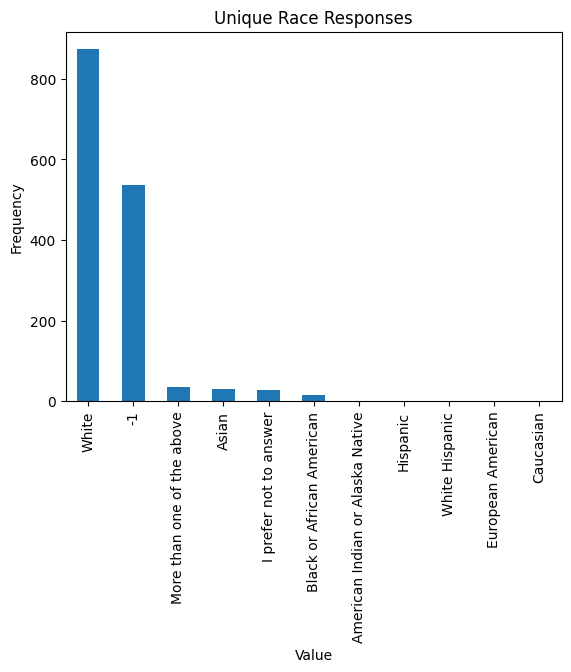

In [30]:
races = df[89]
print(df[89].unique())
# Plot the frequency of each value
races.value_counts().plot(kind='bar')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Unique Race Responses')
plt.show()

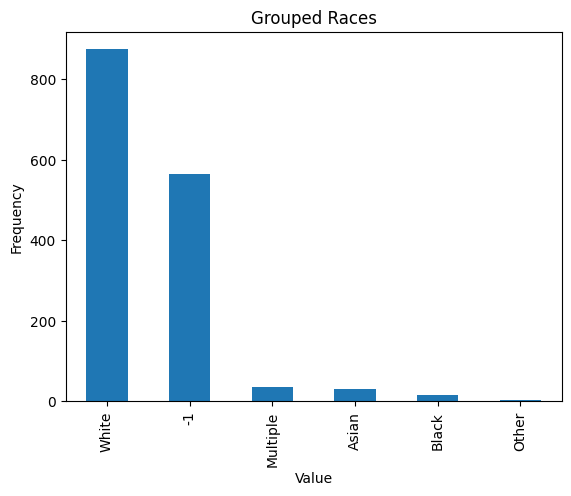

In [40]:
def categorize_race(race):
    if race == 'White' or race == 'Caucasian':
        return 'White'
    elif race == 'Black or African American':
        return 'Black'
    elif race == 'Asian':
        return 'Asian'
    elif race == 'More than one of the above':
        return 'Multiple'
    elif race == '-1' or race == 'I prefer not to answer':
        return '-1'
    elif race in ['American Indian or Alaska Native', 'Hispanic', 'White Hispanic', 'European American']:
        return 'Other'

# Apply the function to the '2' column
df[89] = df[89].apply(categorize_race)

# Now the '2' column should have only 'Male', 'Female', or 'Other' values
df[89].value_counts().plot(kind='bar')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Grouped Races')
plt.show()

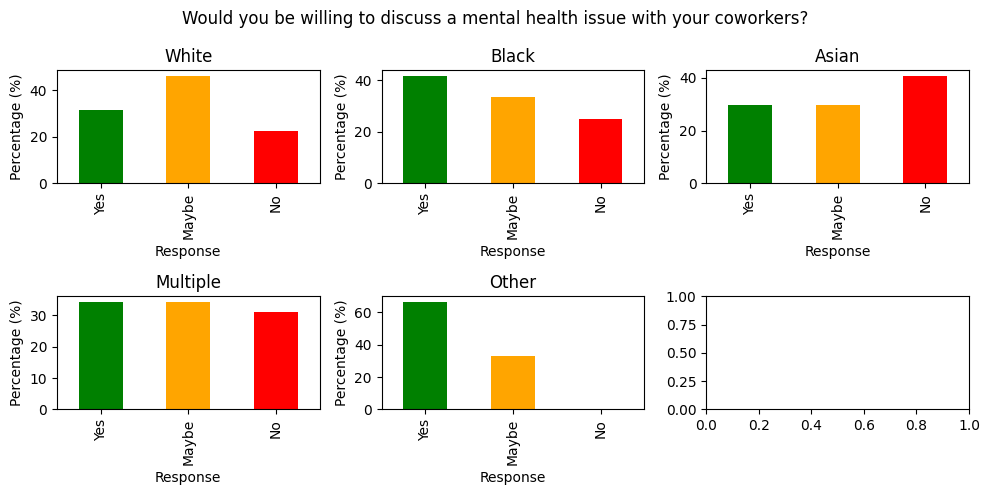

In [43]:
df_white = df.loc[df[89].eq('White')]
df_black = df.loc[df[89].eq('Black')]
df_asian = df.loc[df[89].eq('Asian')]
df_multiple = df.loc[df[89].eq('Multiple')]
df_other_race = df.loc[df[89].eq('Other')]
white_18 = df_white.loc[df_white[18] != '-1'][18].value_counts()
black_18 = df_black.loc[df_black[18] != '-1'][18].value_counts()
asian_18 = df_asian.loc[df_asian[18] != '-1'][18].value_counts()
multiple_18 = df_multiple.loc[df_multiple[18] != '-1'][18].value_counts()
other_races_18 = df_other_race.loc[df_other_race[18] != '-1'][18].value_counts()
total_white = white_18.sum()
white_18 = white_18 / total_white * 100
total_black = black_18.sum()
black_18 = black_18 / total_black * 100
total_asian = asian_18.sum()
asian_18 = asian_18 / total_asian * 100
total_multiple = multiple_18.sum()
multiple_18 = multiple_18 / total_multiple * 100
total_other = other_races_18.sum()
other_races_18 = other_races_18 / total_other * 100
order = ['Yes', 'Maybe', 'No']
white_18 = white_18.reindex(order)
black_18 = black_18.reindex(order)
asian_18 = asian_18.reindex(order)
multiple_18 = multiple_18.reindex(order)
other_races_18 = other_races_18.reindex(order)
colors = ['green', 'orange', 'red']
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

white_18.plot(kind='bar', ax=axs[0][0], color=colors)
axs[0][0].set_xlabel('Response')
axs[0][0].set_ylabel('Percentage (%)')
axs[0][0].set_title('White')

black_18.plot(kind='bar', ax=axs[0][1], color=colors)
axs[0][1].set_xlabel('Response')
axs[0][1].set_ylabel('Percentage (%)')
axs[0][1].set_title('Black')

asian_18.plot(kind='bar', ax=axs[0][2], color=colors)
axs[0][2].set_xlabel('Response')
axs[0][2].set_ylabel('Percentage (%)')
axs[0][2].set_title('Asian')

multiple_18.plot(kind='bar', ax=axs[1][0], color=colors)
axs[1][0].set_xlabel('Response')
axs[1][0].set_ylabel('Percentage (%)')
axs[1][0].set_title('Multiple')

other_races_18.plot(kind='bar', ax=axs[1][1], color=colors)
axs[1][1].set_xlabel('Response')
axs[1][1].set_ylabel('Percentage (%)')
axs[1][1].set_title('Other')

plt.suptitle('Would you be willing to discuss a mental health issue with your coworkers?', fontsize=12)
plt.tight_layout()
plt.show()

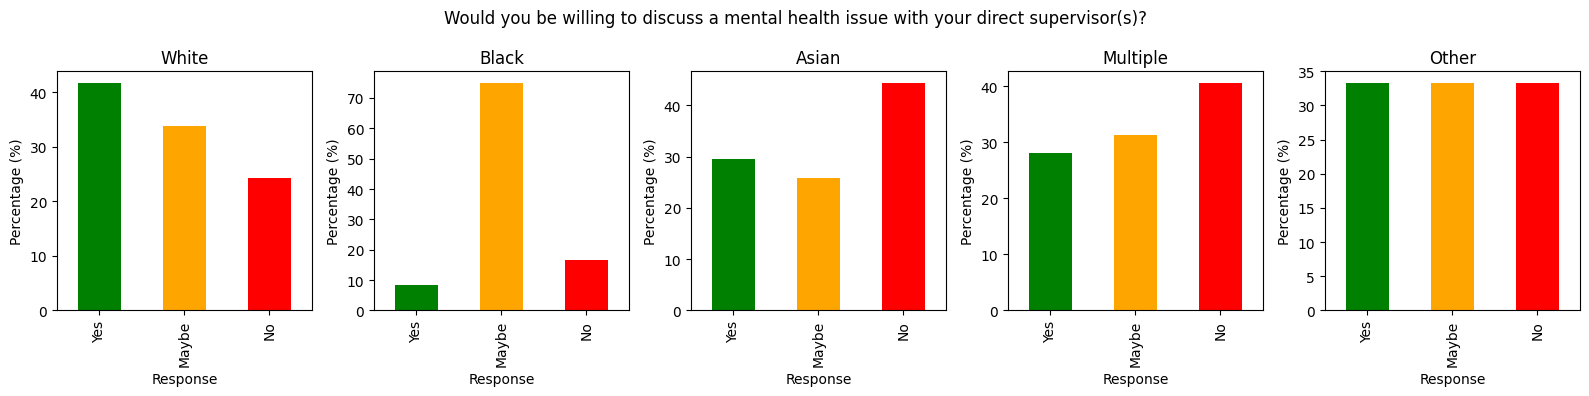

In [11]:
df_white = df.loc[df[89].eq('White')]
df_black = df.loc[df[89].eq('Black')]
df_asian = df.loc[df[89].eq('Asian')]
df_multiple = df.loc[df[89].eq('Multiple')]
df_other_race = df.loc[df[89].eq('Other')]
white_19 = df_white.loc[df_white[19] != '-1'][19].value_counts()
black_19 = df_black.loc[df_black[19] != '-1'][19].value_counts()
asian_19 = df_asian.loc[df_asian[19] != '-1'][19].value_counts()
multiple_19 = df_multiple.loc[df_multiple[19] != '-1'][19].value_counts()
other_races_19 = df_other_race.loc[df_other_race[19] != '-1'][19].value_counts()
total_white = white_19.sum()
white_19 = white_19 / total_white * 100
total_black = black_19.sum()
black_19 = black_19 / total_black * 100
total_asian = asian_19.sum()
asian_19 = asian_19 / total_asian * 100
total_multiple = multiple_19.sum()
multiple_19 = multiple_19 / total_multiple * 100
total_other = other_races_19.sum()
other_races_19 = other_races_19 / total_other * 100
order = ['Yes', 'Maybe', 'No']
white_19 = white_19.reindex(order)
black_19 = black_19.reindex(order)
asian_19 = asian_19.reindex(order)
multiple_19 = multiple_19.reindex(order)
other_races_19 = other_races_19.reindex(order)
colors = ['green', 'orange', 'red']
fig, axs = plt.subplots(1, 5, figsize=(16, 4))

white_19.plot(kind='bar', ax=axs[0], color=colors)
axs[0].set_xlabel('Response')
axs[0].set_ylabel('Percentage (%)')
axs[0].set_title('White')

black_19.plot(kind='bar', ax=axs[1], color=colors)
axs[1].set_xlabel('Response')
axs[1].set_ylabel('Percentage (%)')
axs[1].set_title('Black')

asian_19.plot(kind='bar', ax=axs[2], color=colors)
axs[2].set_xlabel('Response')
axs[2].set_ylabel('Percentage (%)')
axs[2].set_title('Asian')

multiple_19.plot(kind='bar', ax=axs[3], color=colors)
axs[3].set_xlabel('Response')
axs[3].set_ylabel('Percentage (%)')
axs[3].set_title('Multiple')

other_races_19.plot(kind='bar', ax=axs[4], color=colors)
axs[4].set_xlabel('Response')
axs[4].set_ylabel('Percentage (%)')
axs[4].set_title('Other')

plt.suptitle('Would you be willing to discuss a mental health issue with your direct supervisor(s)?', fontsize=12)
plt.tight_layout()
plt.show()

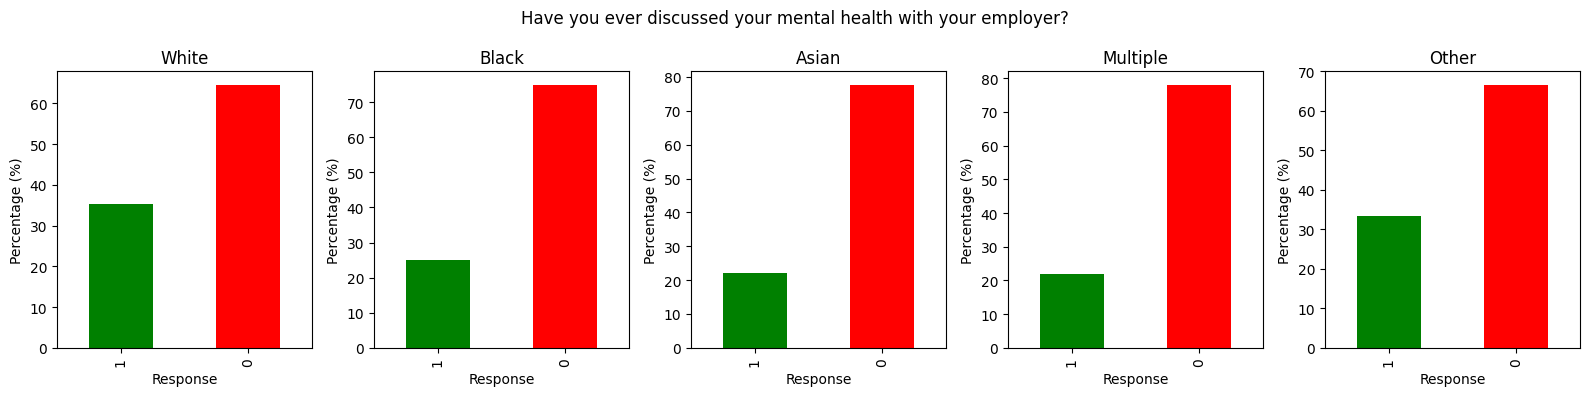

In [12]:
df_white = df.loc[df[89].eq('White')]
df_black = df.loc[df[89].eq('Black')]
df_asian = df.loc[df[89].eq('Asian')]
df_multiple = df.loc[df[89].eq('Multiple')]
df_other_race = df.loc[df[89].eq('Other')]
white_58 = df_white.loc[df_white[58] != '-1'][58].value_counts()
black_58 = df_black.loc[df_black[58] != '-1'][58].value_counts()
asian_58 = df_asian.loc[df_asian[58] != '-1'][58].value_counts()
multiple_58 = df_multiple.loc[df_multiple[58] != '-1'][58].value_counts()
other_races_58 = df_other_race.loc[df_other_race[58] != '-1'][58].value_counts()
total_white = white_58.sum()
white_58 = white_58 / total_white * 100
total_black = black_58.sum()
black_58 = black_58 / total_black * 100
total_asian = asian_58.sum()
asian_58 = asian_58 / total_asian * 100
total_multiple = multiple_58.sum()
multiple_58 = multiple_58 / total_multiple * 100
total_other = other_races_58.sum()
other_races_58 = other_races_58 / total_other * 100
order = ['1', '0']
white_58 = white_58.reindex(order)
black_58 = black_58.reindex(order)
asian_58 = asian_58.reindex(order)
multiple_58 = multiple_58.reindex(order)
other_races_58 = other_races_58.reindex(order)
colors = ['green', 'red']
fig, axs = plt.subplots(1, 5, figsize=(16, 4))

white_58.plot(kind='bar', ax=axs[0], color=colors)
axs[0].set_xlabel('Response')
axs[0].set_ylabel('Percentage (%)')
axs[0].set_title('White')

black_58.plot(kind='bar', ax=axs[1], color=colors)
axs[1].set_xlabel('Response')
axs[1].set_ylabel('Percentage (%)')
axs[1].set_title('Black')

asian_58.plot(kind='bar', ax=axs[2], color=colors)
axs[2].set_xlabel('Response')
axs[2].set_ylabel('Percentage (%)')
axs[2].set_title('Asian')

multiple_58.plot(kind='bar', ax=axs[3], color=colors)
axs[3].set_xlabel('Response')
axs[3].set_ylabel('Percentage (%)')
axs[3].set_title('Multiple')

other_races_58.plot(kind='bar', ax=axs[4], color=colors)
axs[4].set_xlabel('Response')
axs[4].set_ylabel('Percentage (%)')
axs[4].set_title('Other')

plt.suptitle('Have you ever discussed your mental health with your employer?', fontsize=12)
plt.tight_layout()
plt.show()

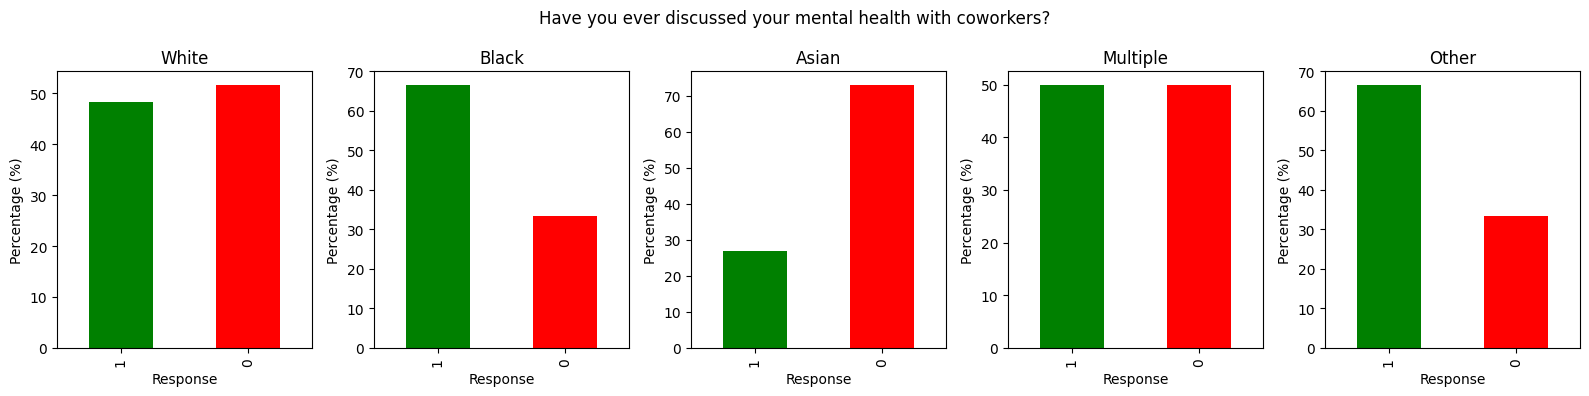

In [13]:
df_white = df.loc[df[89].eq('White')]
df_black = df.loc[df[89].eq('Black')]
df_asian = df.loc[df[89].eq('Asian')]
df_multiple = df.loc[df[89].eq('Multiple')]
df_other_race = df.loc[df[89].eq('Other')]
white_60 = df_white.loc[df_white[60] != '-1'][60].value_counts()
black_60 = df_black.loc[df_black[60] != '-1'][60].value_counts()
asian_60 = df_asian.loc[df_asian[60] != '-1'][60].value_counts()
multiple_60 = df_multiple.loc[df_multiple[60] != '-1'][60].value_counts()
other_races_60 = df_other_race.loc[df_other_race[60] != '-1'][60].value_counts()
total_white = white_60.sum()
white_60 = white_60 / total_white * 100
total_black = black_60.sum()
black_60 = black_60 / total_black * 100
total_asian = asian_60.sum()
asian_60 = asian_60 / total_asian * 100
total_multiple = multiple_60.sum()
multiple_60 = multiple_60 / total_multiple * 100
total_other = other_races_60.sum()
other_races_60 = other_races_60 / total_other * 100
order = ['1', '0']
white_60 = white_60.reindex(order)
black_60 = black_60.reindex(order)
asian_60 = asian_60.reindex(order)
multiple_60 = multiple_60.reindex(order)
other_races_60 = other_races_60.reindex(order)
colors = ['green', 'red']
fig, axs = plt.subplots(1, 5, figsize=(16, 4))

white_60.plot(kind='bar', ax=axs[0], color=colors)
axs[0].set_xlabel('Response')
axs[0].set_ylabel('Percentage (%)')
axs[0].set_title('White')

black_60.plot(kind='bar', ax=axs[1], color=colors)
axs[1].set_xlabel('Response')
axs[1].set_ylabel('Percentage (%)')
axs[1].set_title('Black')

asian_60.plot(kind='bar', ax=axs[2], color=colors)
axs[2].set_xlabel('Response')
axs[2].set_ylabel('Percentage (%)')
axs[2].set_title('Asian')

multiple_60.plot(kind='bar', ax=axs[3], color=colors)
axs[3].set_xlabel('Response')
axs[3].set_ylabel('Percentage (%)')
axs[3].set_title('Multiple')

other_races_60.plot(kind='bar', ax=axs[4], color=colors)
axs[4].set_xlabel('Response')
axs[4].set_ylabel('Percentage (%)')
axs[4].set_title('Other')

plt.suptitle('Have you ever discussed your mental health with coworkers?', fontsize=12)
plt.tight_layout()
plt.show()

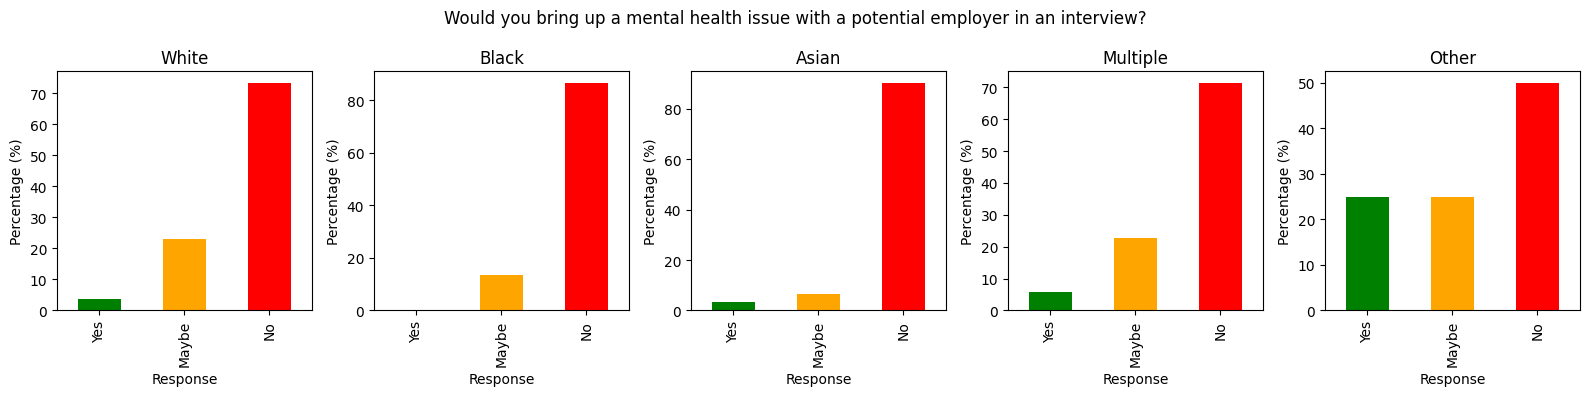

In [14]:
df_white = df.loc[df[89].eq('White')]
df_black = df.loc[df[89].eq('Black')]
df_asian = df.loc[df[89].eq('Asian')]
df_multiple = df.loc[df[89].eq('Multiple')]
df_other_race = df.loc[df[89].eq('Other')]
white_12 = df_white.loc[df_white[12] != '-1'][12].value_counts()
black_12 = df_black.loc[df_black[12] != '-1'][12].value_counts()
asian_12 = df_asian.loc[df_asian[12] != '-1'][12].value_counts()
multiple_12 = df_multiple.loc[df_multiple[12] != '-1'][12].value_counts()
other_races_12 = df_other_race.loc[df_other_race[12] != '-1'][12].value_counts()
total_white = white_12.sum()
white_12 = white_12 / total_white * 100
total_black = black_12.sum()
black_12 = black_12 / total_black * 100
total_asian = asian_12.sum()
asian_12 = asian_12 / total_asian * 100
total_multiple = multiple_12.sum()
multiple_12 = multiple_12 / total_multiple * 100
total_other = other_races_12.sum()
other_races_12 = other_races_12 / total_other * 100
order = ['Yes', 'Maybe', 'No']
white_12 = white_12.reindex(order)
black_12 = black_12.reindex(order)
asian_12 = asian_12.reindex(order)
multiple_12 = multiple_12.reindex(order)
other_races_12 = other_races_12.reindex(order)
colors = ['green', 'orange', 'red']
fig, axs = plt.subplots(1, 5, figsize=(16, 4))

white_12.plot(kind='bar', ax=axs[0], color=colors)
axs[0].set_xlabel('Response')
axs[0].set_ylabel('Percentage (%)')
axs[0].set_title('White')

black_12.plot(kind='bar', ax=axs[1], color=colors)
axs[1].set_xlabel('Response')
axs[1].set_ylabel('Percentage (%)')
axs[1].set_title('Black')

asian_12.plot(kind='bar', ax=axs[2], color=colors)
axs[2].set_xlabel('Response')
axs[2].set_ylabel('Percentage (%)')
axs[2].set_title('Asian')

multiple_12.plot(kind='bar', ax=axs[3], color=colors)
axs[3].set_xlabel('Response')
axs[3].set_ylabel('Percentage (%)')
axs[3].set_title('Multiple')

other_races_12.plot(kind='bar', ax=axs[4], color=colors)
axs[4].set_xlabel('Response')
axs[4].set_ylabel('Percentage (%)')
axs[4].set_title('Other')

plt.suptitle('Would you bring up a mental health issue with a potential employer in an interview?', fontsize=12)
plt.tight_layout()
plt.show()

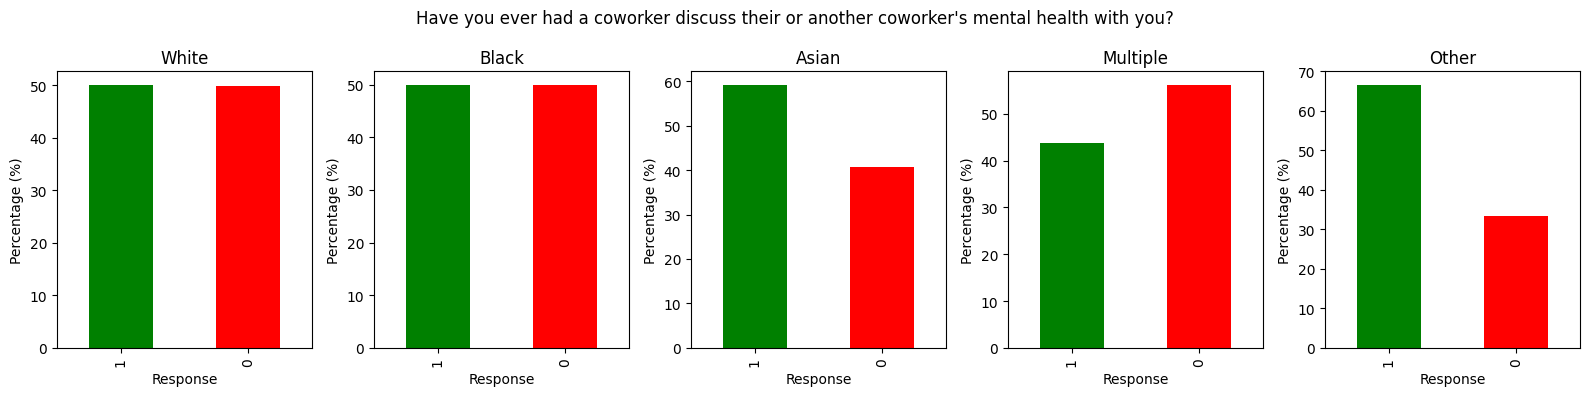

In [15]:
df_white = df.loc[df[89].eq('White')]
df_black = df.loc[df[89].eq('Black')]
df_asian = df.loc[df[89].eq('Asian')]
df_multiple = df.loc[df[89].eq('Multiple')]
df_other_race = df.loc[df[89].eq('Other')]
white_62 = df_white.loc[df_white[62] != '-1'][62].value_counts()
black_62 = df_black.loc[df_black[62] != '-1'][62].value_counts()
asian_62 = df_asian.loc[df_asian[62] != '-1'][62].value_counts()
multiple_62 = df_multiple.loc[df_multiple[62] != '-1'][62].value_counts()
other_races_62 = df_other_race.loc[df_other_race[62] != '-1'][62].value_counts()
total_white = white_62.sum()
white_62 = white_62 / total_white * 100
total_black = black_62.sum()
black_62 = black_62 / total_black * 100
total_asian = asian_62.sum()
asian_62 = asian_62 / total_asian * 100
total_multiple = multiple_62.sum()
multiple_62 = multiple_62 / total_multiple * 100
total_other = other_races_62.sum()
other_races_62 = other_races_62 / total_other * 100
order = ['1', '0']
white_62 = white_62.reindex(order)
black_62 = black_62.reindex(order)
asian_62 = asian_62.reindex(order)
multiple_62 = multiple_62.reindex(order)
other_races_62 = other_races_62.reindex(order)
colors = ['green', 'red']
fig, axs = plt.subplots(1, 5, figsize=(16, 4))

white_62.plot(kind='bar', ax=axs[0], color=colors)
axs[0].set_xlabel('Response')
axs[0].set_ylabel('Percentage (%)')
axs[0].set_title('White')

black_62.plot(kind='bar', ax=axs[1], color=colors)
axs[1].set_xlabel('Response')
axs[1].set_ylabel('Percentage (%)')
axs[1].set_title('Black')

asian_62.plot(kind='bar', ax=axs[2], color=colors)
axs[2].set_xlabel('Response')
axs[2].set_ylabel('Percentage (%)')
axs[2].set_title('Asian')

multiple_62.plot(kind='bar', ax=axs[3], color=colors)
axs[3].set_xlabel('Response')
axs[3].set_ylabel('Percentage (%)')
axs[3].set_title('Multiple')

other_races_62.plot(kind='bar', ax=axs[4], color=colors)
axs[4].set_xlabel('Response')
axs[4].set_ylabel('Percentage (%)')
axs[4].set_title('Other')

plt.suptitle('Have you ever had a coworker discuss their or another coworker\'s mental health with you?', fontsize=12)
plt.tight_layout()
plt.show()

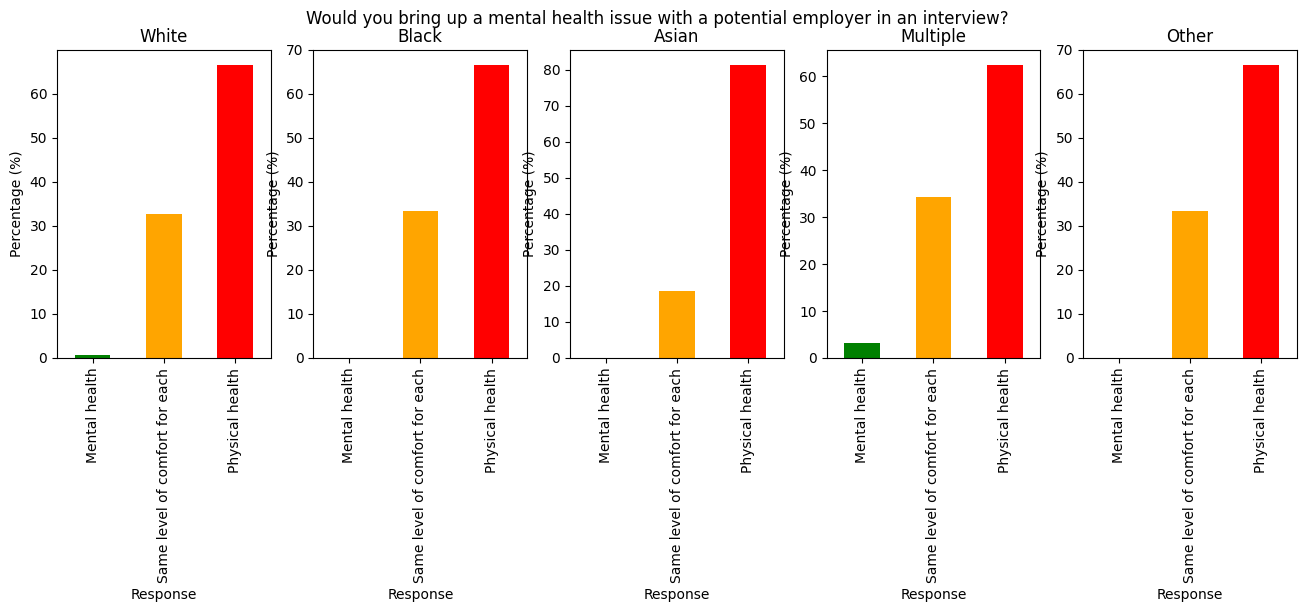

In [18]:
df_white = df.loc[df[89].eq('White')]
df_black = df.loc[df[89].eq('Black')]
df_asian = df.loc[df[89].eq('Asian')]
df_multiple = df.loc[df[89].eq('Multiple')]
df_other_race = df.loc[df[89].eq('Other')]
white_57 = df_white.loc[df_white[57] != '-1'][57].value_counts()
black_57 = df_black.loc[df_black[57] != '-1'][57].value_counts()
asian_57 = df_asian.loc[df_asian[57] != '-1'][57].value_counts()
multiple_57 = df_multiple.loc[df_multiple[57] != '-1'][57].value_counts()
other_races_57 = df_other_race.loc[df_other_race[57] != '-1'][57].value_counts()
total_white = white_57.sum()
white_57 = white_57 / total_white * 100
total_black = black_57.sum()
black_57 = black_57 / total_black * 100
total_asian = asian_57.sum()
asian_57 = asian_57 / total_asian * 100
total_multiple = multiple_57.sum()
multiple_57 = multiple_57 / total_multiple * 100
total_other = other_races_57.sum()
other_races_57 = other_races_57 / total_other * 100
order = ['Mental health', 'Same level of comfort for each', 'Physical health']
white_57 = white_57.reindex(order)
black_57 = black_57.reindex(order)
asian_57 = asian_57.reindex(order)
multiple_57 = multiple_57.reindex(order)
other_races_57 = other_races_57.reindex(order)
colors = ['green', 'orange', 'red']
fig, axs = plt.subplots(1, 5, figsize=(16, 4))

white_57.plot(kind='bar', ax=axs[0], color=colors)
axs[0].set_xlabel('Response')
axs[0].set_ylabel('Percentage (%)')
axs[0].set_title('White')

black_57.plot(kind='bar', ax=axs[1], color=colors)
axs[1].set_xlabel('Response')
axs[1].set_ylabel('Percentage (%)')
axs[1].set_title('Black')

asian_57.plot(kind='bar', ax=axs[2], color=colors)
axs[2].set_xlabel('Response')
axs[2].set_ylabel('Percentage (%)')
axs[2].set_title('Asian')

multiple_57.plot(kind='bar', ax=axs[3], color=colors)
axs[3].set_xlabel('Response')
axs[3].set_ylabel('Percentage (%)')
axs[3].set_title('Multiple')

other_races_57.plot(kind='bar', ax=axs[4], color=colors)
axs[4].set_xlabel('Response')
axs[4].set_ylabel('Percentage (%)')
axs[4].set_title('Other')

plt.suptitle('Would you feel more comfortable talking to your coworkers about your physical health or your mental health?', fontsize=12)
#plt.tight_layout()
plt.show()